In [1]:
# magic to reload modules when they change
%load_ext autoreload
%autoreload 2

# Dynamic Analysis of a bridge structure

## Geometry of the bridge

In [2]:
import os
import time
import shutil
import logging
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from sympy import Matrix, lambdify
from utils.geometric import *
from truss_constraints import *
from utils.truss_helpers import *
from sympy.utilities.codegen import codegen
import cython

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

In [9]:
span = 25
angle = 45
beam_length = 2.5
skip_rod = []
truss_mode = "howe" # warren, pratt, howe, simple, simple_cant 

if "simple" not in truss_mode:
    # Calculation of bridge geometry
    height, spacing, diag = calculate_bridge(span, angle, beam_length, truss_mode)
    n_columns, n_nod_tot, n_rods, n_beams, n_ele_tot, n_bot_beams = calculate_essential_elements(span, spacing, truss_mode, skip_rod)

    # Recalculates the skip_rod to match the truss design
    skip_rod = truss_design(n_bot_beams, n_rods, truss_mode)
    n_columns, n_nod_tot, n_rods, n_beams, n_ele_tot, n_bot_beams = calculate_essential_elements(span, spacing, truss_mode, skip_rod)
else:
    n_columns, n_nod_tot, n_rods, n_beams, n_ele_tot, n_bot_beams = calculate_simple_elements(span, spacing, truss_mode, skip_rod)


# Calculation of nodal coordinates and construction of par, pel matrices and element node indices
# Building priorty: Beams -> Columns -> Rods
nodal_coord, par, pel, ele_nod, n_par_tot = calculate_element_node(span, spacing, height, n_dim, n_par_nod, truss_mode, skip_rod)

# Seperating nodal coordinates into x and y coordinates
X = np.zeros(n_nod_tot, dtype=float)
Y = np.zeros(n_nod_tot, dtype=float)
X[:] = nodal_coord[:, 0]
Y[:] = nodal_coord[:, 1]


# -------- BOUNDARY CONDITIONS --------
# Focuses only on the first and last node connect to the ground (roller, pin, fixed)
W = boundary_conditions(n_bot_beams, n_par_nod, n_nod_tot, supports=["pin", "roller"])
pel = pel.astype(np.int32)
W = W.astype(np.int32)
ele_nod = ele_nod.astype(np.int32)


# # -------- ELEMENT CHARACTERIZING DATA --------
h = np.zeros(n_ele_tot, dtype=np.float32)
J = np.zeros(n_ele_tot, dtype=np.float32)
A = np.zeros(n_ele_tot, dtype=np.float32)
beta = np.zeros(n_ele_tot,dtype=np.float32)
ro = np.zeros(n_ele_tot,dtype=np.float32)
E = np.zeros(n_ele_tot, dtype=np.float32)


# # -------- ELEMENT PROPERTIES --------
J, A, h, beta, ro, E, G = calculate_element_properties(n_columns, n_beams, diag, spacing, height, J, A, h, beta, ro, E, X, Y, ele_nod, shear_mod,
                                                 width_properties, height_properties, unit_weight_properties, elastic_mod_properties)
beam_indices = np.arange(n_ele_tot - n_rods, dtype=np.int32)
rod_indices = np.arange(n_ele_tot - n_rods, n_ele_tot, dtype=np.int32)

In [10]:
# # J, A, h, beta, ro, E, X, Y, ele_nod, W
# # Save 2d numpy array to csv
# np.savetxt("ele_nod.csv", ele_nod, delimiter=",")
# np.savetxt("X.csv", X, delimiter=",")
# np.savetxt("Y.csv", Y, delimiter=",")

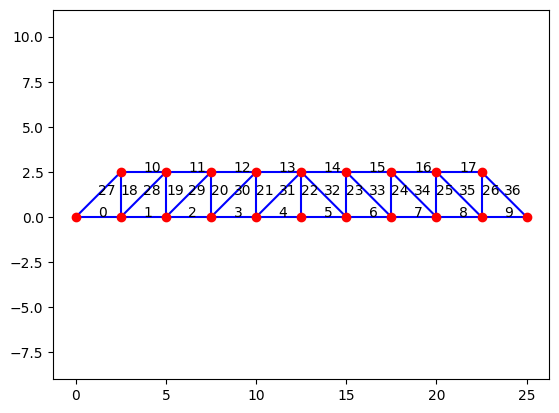

In [11]:
# Plot each element using its angle beta
for i in range(len(ele_nod)):
    x1, y1 = X[ele_nod[i, 0]], Y[ele_nod[i, 0]]  # Start node
    length = h[i]
    # Calculate end point based on length and angle beta
    x2 = x1 + length * np.cos(beta[i])
    y2 = y1 + length * np.sin(beta[i])

    
    plt.plot([x1, x2], [y1, y2], 'b')  # Plot element
    plt.text((x1 + x2) / 2, (y1 + y2) / 2, str(i))  # Label element

plt.plot(X, Y, 'ro')  # Plot nodes
plt.axis('equal')
plt.show()

## Bridge displacements and matrix construction

In [59]:
beam_type = "bernoulli"
use_lagrangian = False

(x, xi, h_e, beta_e, beta_curr, qe, a_arr, b_arr,
    c_arr, d_arr, e_arr, A_e, E_e, J_e, ro_e, T, fo_E, X_old, Y_old,
        Qglo_pel_curr, w_arr, r_arr, f_arr, g_arr) = initialize_symbols(n_par_ele)

v1, u1, v2, u2 = compute_v_u(qe, beta_e)


(ve_beam_func, ue_beam_func, ve_beam, ue_beam, ve_rod_func, 
    ue_rod_func, ve_rod, ue_rod, alpha_e_beam) = calculate_displacement_equations(x, xi, h_e, beta_e, qe, a_arr, b_arr, c_arr, d_arr, e_arr,
                                     beam_type, use_lagrangian)

pot_beam, kin_beam, pot_rod, kin_rod = calculate_energies(beam_type, ve_beam, ue_beam, alpha_e_beam, ve_rod,
                                                          ue_rod, x, h_e, E_e, J_e, A_e, ro_e, G, k_shear)

(K_beam, M_beam, K_rod, M_rod, K_beam_func, M_beam_func, 
 K_rod_func, M_rod_func) = construct_lambdified_matrices(n_par_ele, pot_beam, kin_beam, pot_rod, kin_rod, 
                                                         qe, h_e, A_e, E_e, J_e, beta_e, ro_e)



(X_new_beam, Y_new_beam, X_new_rod, Y_new_rod, X_new_beam_func, Y_new_beam_func, 
 X_new_rod_func, Y_new_rod_func) = calculate_global_displacements(Qglo_pel_curr, beta_e, h_e, x, xi, f_arr, 
                                                                         g_arr, w_arr, r_arr, beam_type,
                                                                         X_old, Y_old, use_lagrangian)


In [60]:
%%capture
#Turn the symbolic functions into lambdified functions suitable for Cython
functions = [
    ("K_beam_func", K_beam),
    ("M_beam_func", M_beam),
    ("K_rod_func", K_rod),
    ("M_rod_func", M_rod),
]

# Generate C code
codegen(
    functions,
    language="C",
    project="utils/cython",
    to_files=True
)


functions = [
    ("X_beam_func", X_new_beam),
    ("Y_beam_func", Y_new_beam),
    ("X_rod_func", X_new_rod),
    ("Y_rod_func", Y_new_rod),
]

# Generate C code
codegen(
    functions,
    language="C",
    project="utils/cython",
    to_files=True
)


def replace_include_guards(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Replace slashes with underscores in the include guards
    content = content.replace('UTILS/CYTHON__', 'UTILS_CYTHON__')
    
    # Add whitespace after the define directive if missing
    content = content.replace('#defineUTILS_CYTHON__', '#define UTILS_CYTHON__')
    
    with open(file_path, 'w') as file:
        file.write(content)

# Paths to the header files
header_files = [
    "K_beam_func.h",
    "X_beam_func.h"
]

# Move the generated C files and modify the include guards in the header files
for header_file in header_files:
    source_path = header_file
    dest_path = os.path.join("utils/cython", header_file)
    
    # Replace include guards
    replace_include_guards(source_path)
    
    # Move the header file to the destination
    shutil.move(source_path, dest_path)

# Move the generated C files
shutil.move("K_beam_func.c", "utils/cython/K_beam_func.c")
shutil.move("X_beam_func.c", "utils/cython/X_beam_func.c")

!cd utils/cython && python setup.py build_ext --inplace

from utils.cython.assemble_matrices import assemble_global_matrices_cython, apply_boundary_conditions_cython, compute_element_matrices_cython, compute_element_coordinates_cython

In [61]:
# Construct stiffness using Cython
start_time = time.time()
for i in range(2000):
    element_matrices = compute_element_matrices_cython(
        n_ele_tot, beam_indices, rod_indices,
        h, A, E, J, beta, ro
    )
    K, M = assemble_global_matrices_cython(element_matrices, pel, n_par_tot)
    K, M = apply_boundary_conditions_cython(K, M, W, tol=1e-5)
print(f"Time taken: {time.time() - start_time}")

Time taken: 0.47911882400512695


In [15]:
# Same commands as above, but using the Python implementation
K, M = assemble_global_matrices(n_par_ele, n_par_tot, n_ele_tot, K_beam_func, M_beam_func, K_rod_func, M_rod_func,
                                h, A, E, J, beta, ro, pel, n_rods)
K, M = apply_boundary_conditions(K, M, W, tol=1e-5)


In [62]:
check_matrix(K) 
check_matrix(M)
W

Matrix is symmetric
Matrix is well-conditioned
Number of diagonal elements not the biggest in their row: 0
Matrix is symmetric
Matrix is well-conditioned
Number of diagonal elements not the biggest in their row: 2


array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [63]:
print_matrix(M)
print_matrix(K)

                 1        2        3        4        5        6        7        8        9       10       11       12       13       14       15       16       17       18       19       20       21       22       23       24       25       26       27       28       29       30       31       32       33       34       35       36       37       38       39       40       41       42       43       44       45       46       47       48       49       50       51       52       53       54       55       56       57       58       59       60       61       62       63
        1  1.0e-02  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00

## Solve the eigenvalue problem

In [64]:
# Compute eigenvalues and eigenvectors using scipy method without filtering
lamb_r, phis_norm = compute_eigenvalues_and_eigenvectors(K, M, method='numpy', filter_numerical_stability=True, threshold=1e-10)
index_modes, sorted_period, _ = get_mode_indices(lamb_r, phis_norm, n_plots)

# Extract lambdas and corresponding eigenvectors
lamb_plots = lamb_r[index_modes]
phis_plots = phis_norm[:, index_modes]

# Print sorted periods
print("Sorted Periods:", sorted_period)
print("Selected Modes Periods:", sorted_period[index_modes])
print(f"The frequencies of the first {n_plots} plots are {np.sqrt(lamb_r[index_modes])}")


Sorted Periods: [6.2831852e-05 6.2831852e-05 6.2831852e-05 3.0527702e-03 3.0741275e-03
 3.1980430e-03 3.2748086e-03 3.5614329e-03 3.6830108e-03 4.1765701e-03
 4.3233656e-03 4.9362774e-03 4.9743573e-03 5.0957748e-03 5.2740346e-03
 5.5227350e-03 5.7259393e-03 5.9658084e-03 6.3299225e-03 6.4229560e-03
 6.7138150e-03 6.8042683e-03 7.3289913e-03 7.7906144e-03 8.4507326e-03
 8.6887628e-03 8.9044319e-03 9.1098202e-03 1.0123319e-02 1.0268077e-02
 1.1461338e-02 1.1903938e-02 1.2018296e-02 1.2968341e-02 1.3603333e-02
 1.3734868e-02 1.4601968e-02 1.5261575e-02 1.6079368e-02 1.6352529e-02
 1.8777132e-02 1.8988380e-02 1.9630572e-02 2.0302791e-02 2.1436589e-02
 2.2775391e-02 2.4124010e-02 2.5150336e-02 2.5173694e-02 2.5308352e-02
 2.5642516e-02 2.5746090e-02 2.5884101e-02 2.8073095e-02 3.2082811e-02
 3.4891736e-02 3.8063943e-02 4.6775740e-02 6.0098838e-02 8.2147039e-02
 8.7383635e-02 1.3213333e-01 3.2064438e-01]
Selected Modes Periods: [0.32064438 0.13213333 0.08738364 0.08214704]
The frequencies of

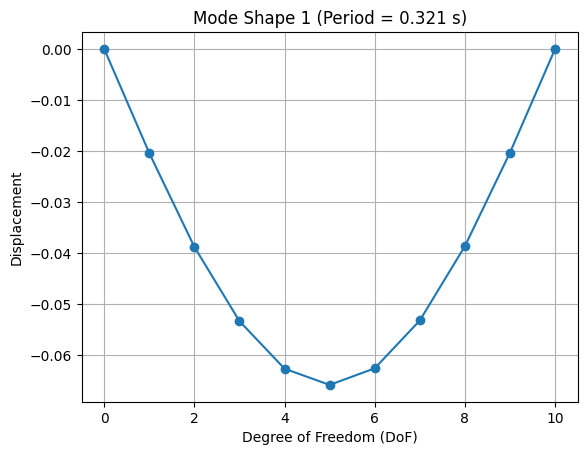

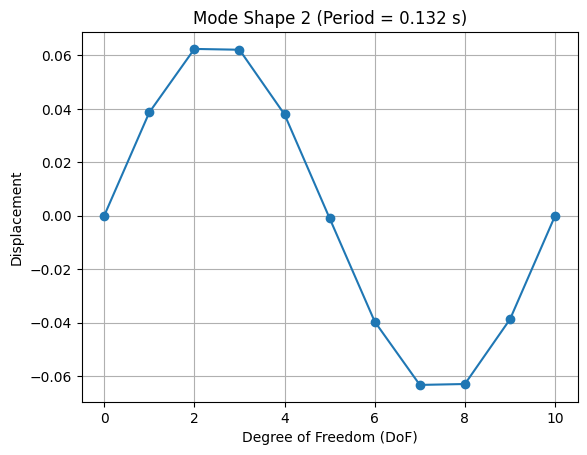

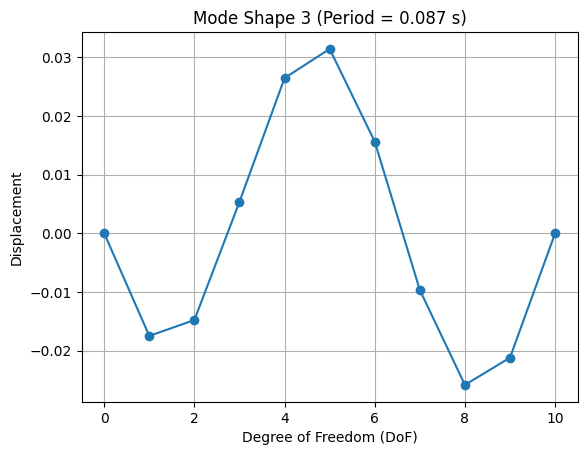

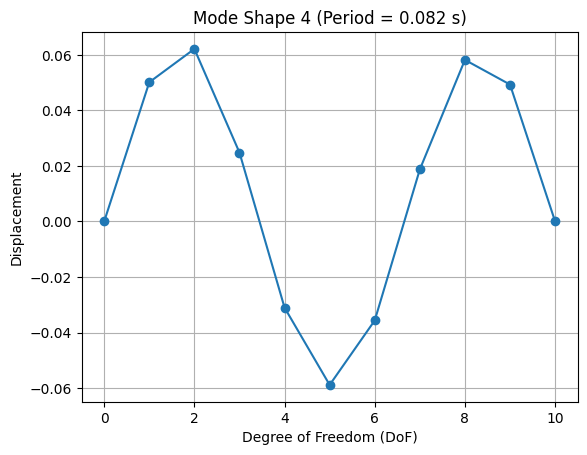

In [65]:
# Plot the relationship between the period and the mode shape
# Shows the expected displacement at each node for each mode
skip_dof = 3
dof_start = 1
for i, selected_mode in enumerate(index_modes):  # Plot up to 5 mode shapes
    plt.figure()
    try:
        plt.plot(phis_norm[dof_start:(n_bot_beams+1)*n_par_nod:skip_dof, selected_mode], 'o-')  # Assuming a 1D structure
    except:
        print("Error: normalized")
        plt.plot(phis_r[dof_start:(n_bot_beams+1)*n_par_nod:skip_dof, selected_mode], 'o-')  # Assuming a 1D structure
    plt.title(f"Mode Shape {i+1} (Period = {sorted_period[-i-1]:.3f} s)")
    plt.xlabel("Degree of Freedom (DoF)")
    plt.ylabel("Displacement")
    plt.grid()
    plt.show()


## Bridge Output for Mode Shapes

In [66]:
# Compute the displacement of each node for each mode using Cython
X_new_sub, Y_new_sub, X_disp, Y_disp = compute_element_coordinates_cython(
    n_plots, n_ele_tot, n_rods, n_discritizations, span, spacing,
    X, Y, ele_nod, beta, h, pel, phis_plots, use_lagrangian
)


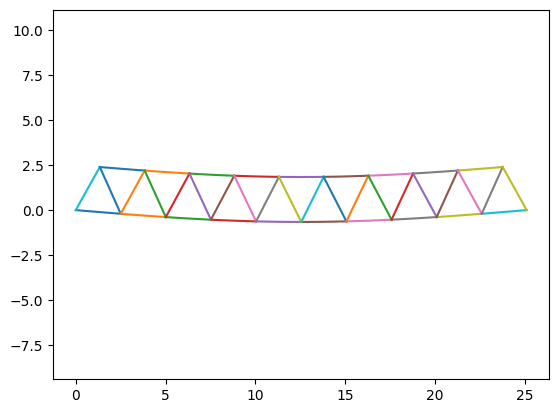

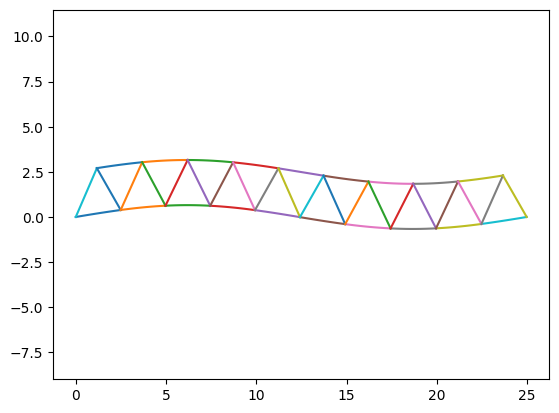

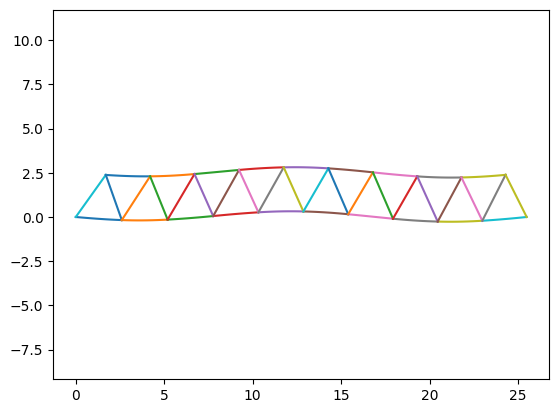

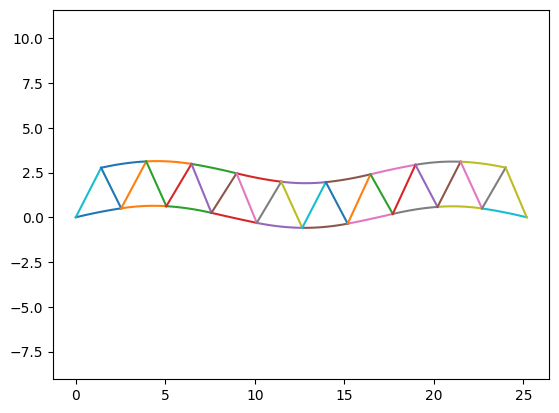

In [67]:
# Define lists
X_new_sub = np.zeros((n_plots, n_ele_tot, n_discritizations))
Y_new_sub = np.zeros((n_plots, n_ele_tot, n_discritizations))
X_disp = np.zeros((n_plots, n_ele_tot))
Y_disp = np.zeros((n_plots, n_ele_tot))

amplifier = int(span/spacing)

# Iterate over n_plots and n_ele_tot
for j in range(n_plots):
    plt.figure()  # Create a new figure for each mode
    for e in range(n_ele_tot):
        # Choose beam or rod functions
        if e < n_ele_tot - n_rods:
            x_func = X_new_beam_func
            y_func = Y_new_beam_func
        else:
            x_func = X_new_rod_func
            y_func = Y_new_rod_func

        # Prepare arguments for the lambda functions
        func_args = (
            X[ele_nod[e, 0]],
            Y[ele_nod[e, 0]],
            beta[e],
            h[e],
        ) + tuple(phis_plots[pel[e, i]-1, j]*amplifier for i in range(n_par_ele))

        # Generate plot values
        if use_lagrangian:
            plot_values = np.linspace(0, 1, 10)
        else:
            plot_values = np.linspace(0, h[e], 10)

        # Calculate new coordinates
        X_new_sub[j][e] = x_func(plot_values, *func_args)
        Y_new_sub[j][e] = y_func(plot_values, *func_args)

        plt.plot(X_new_sub[j][e], Y_new_sub[j][e])  # Plot elements for the current mode

        # Save the displacement in the X direction
        X_disp[j, e] = X_new_sub[j][e][-1] - X_new_sub[j][e][0]
        Y_disp[j, e] = Y_new_sub[j][e][-1] - Y_new_sub[j][e][0]

    plt.axis('equal')  # Make x and y axes have the same scale
    plt.show()  # Display the plot for the current mode

In [60]:
# X_new_sub -> plot, element, discretization
# element -> ele_nod[e, 0]
# node -> nodal_coord[ele_nod[e, 0], 0]
X_new_sub[0][1][-1] - nodal_coord[ele_nod[1, 1], 0], phis_plots[6,0]

(np.float64(-0.018309728475287557), np.float64(-0.0009154864237643778))

In [16]:
X_disp[0], X_new_sub[0][1][-1] - X_new_sub[0][1][0]

(array([ 2.50289321,  2.50674198,  2.51000833,  2.51235496,  2.51354608,
         2.5134569 ,  2.51208835,  2.50956662,  2.50612883,  2.50211014,
         2.49595068,  2.49225815,  2.489326  ,  2.48744352,  2.48679371,
         2.48743916,  2.48931573,  2.49223938,  2.49592069,  1.338034  ,
        -1.16485875,  1.33109147, -1.17565005,  1.31660764, -1.19340022,
         1.29592532, -1.21642918,  1.27101387, -1.24253174,  1.24426151,
        -1.26919493,  1.21824377, -1.29384411,  1.19547116, -1.314095  ,
         1.17814392, -1.32798444,  1.16793579, -1.3341739 ]),
 np.float64(2.506741982565898))

In [15]:
X_disp[0], X_new_sub[0][1][-1] - X_new_sub[0][1][0]

(array([ 2.50289309,  2.50674186,  2.51000821,  2.51235484,  2.51354596,
         2.51345678,  2.51208823,  2.5095665 ,  2.50612871,  2.50211002,
         2.49595056,  2.49225803,  2.48932588,  2.4874434 ,  2.48679359,
         2.48743904,  2.48931562,  2.49223926,  2.49592057,  1.33803401,
        -1.16485872,  1.33109148, -1.17565002,  1.31660765, -1.19340019,
         1.29592533, -1.21642915,  1.27101388, -1.24253171,  1.24426152,
        -1.2691949 ,  1.21824379, -1.29384408,  1.19547118, -1.31409497,
         1.17814394, -1.32798442,  1.1679358 , -1.33417387]),
 np.float64(2.5067418630351312))

In [20]:
# Get dimension of X_disp
X_disp.shape, phis_plots.shape, X_disp[0], n_nod_tot

((4, 39),
 (63, 4),
 array([ 2.50289309,  2.50674186,  2.51000821,  2.51235484,  2.51354596,
         2.51345678,  2.51208823,  2.5095665 ,  2.50612871,  2.50211002,
         2.49595056,  2.49225803,  2.48932588,  2.4874434 ,  2.48679359,
         2.48743904,  2.48931562,  2.49223926,  2.49592057,  1.33803401,
        -1.16485872,  1.33109148, -1.17565002,  1.31660765, -1.19340019,
         1.29592533, -1.21642915,  1.27101388, -1.24253171,  1.24426152,
        -1.2691949 ,  1.21824379, -1.29384408,  1.19547118, -1.31409497,
         1.17814394, -1.32798442,  1.1679358 , -1.33417387]),
 21)

In [44]:
# Get dimension of X_disp
X_disp.shape, phis_plots.shape, X_disp[0], X_disp[1]

((39, 4),
 (63, 4),
 array([2.49710688, 2.51107104, 2.39769564, 2.46241069]),
 array([2.4932581 , 2.51996989, 2.40834231, 2.47984783]))

## Dataset Creation
Must first create the geometry of the building

In [31]:
import pandas as pd
from itertools import combinations, product
import random
### E damages 25 and 50 percent considered for up to 3 elements + mixed 4 and 5 elements 60k combinations
## Last data set 4 5 6 are fully generated (21 mins) and taken as a subset
# Use the lazy evaluation to generate the data for 4 5 6 elements and save it 
E_values = [E[0], E[0]*0.25, E[0]*0.5]
max_mixed = 7

In [23]:
def generate_custom_combinations_lazy(n_ele_tot, max_mixed, E_values):
    """
    Generate combinations with up to 'max_mixed' elements having mixed E values, lazily.
    
    Parameters:
    n_ele_tot (int): Total number of elements.
    max_mixed (int): Maximum number of elements to have mixed E values.
    E_values (numpy.ndarray or list): Array of possible E values.
    
    Yields:
    numpy.ndarray: A combination of E values.
    """
    E_values = np.array(E_values)

    if not E_values.ndim == 1:
        raise ValueError("E_values must be a 1D array of scalars.")
    
    for num_changes in range(max_mixed + 1):
        for indices in combinations(range(n_ele_tot), num_changes):
            base = np.full(n_ele_tot, E_values[0], dtype=E_values.dtype)
            for changed_values in product(E_values[1:], repeat=num_changes):
                new_comb = base.copy()
                for idx, value in zip(indices, changed_values):
                    new_comb[idx] = np.array(value, dtype=E_values.dtype)
                yield new_comb

comb_res2 = generate_custom_combinations_lazy(n_ele_tot, max_mixed, E_values)
comb_res2 = list(comb_res2)
len(comb_res2)

163856499

In [19]:
def generate_custom_combinations(n_ele_tot, max_mixed, E_values):
    """
    Generate combinations with up to 'max_mixed' elements having mixed E values.
    
    Parameters:
    n_ele_tot (int): Total number of elements.
    max_mixed (int): Maximum number of elements to have mixed E values.
    E_values (numpy.ndarray or list): Array of possible E values.
    
    Returns:
    list: List of combinations of E values.
    """
    # Convert E_values to a NumPy array if it's not already one
    E_values = np.array(E_values)

    if not E_values.ndim == 1:
        raise ValueError("E_values must be a 1D array of scalars.")
    
    result_combinations = []
    
    for num_changes in range(max_mixed + 1):
        for indices in combinations(range(n_ele_tot), num_changes):
            base = np.full(n_ele_tot, E_values[0], dtype=E_values.dtype)
            for changed_values in product(E_values[1:], repeat=num_changes):
                new_comb = base.copy()
                for idx, value in zip(indices, changed_values):
                    # Ensure value is of the same type as E_values elements
                    new_comb[idx] = np.array(value, dtype=E_values.dtype)
                result_combinations.append(new_comb)
    
    return result_combinations

comb_res = generate_custom_combinations(n_ele_tot, max_mixed, E_values)
comb_res = list(comb_res)

### Part 1: Generate elements 1 2 3 4

In [21]:
# Save the first 130k combinations to csv
comb_res = generate_custom_combinations(n_ele_tot, max_mixed, E_values)
comb_res = list(comb_res)

df = pd.DataFrame(comb_res[:130000])


True

### Part 2: Generate elements 4 5 and take a subset of 60k for elements 4 5

In [34]:
# Generate elements 4 5 
comb_res = generate_custom_combinations(n_ele_tot, max_mixed, E_values)
comb_res = list(comb_res)

df2 = pd.DataFrame(comb_res[150000:])

# Randomly sample 60k rows
df2 = df2.sample(n=60000, random_state=42)

# Concat the two dataframes
pd.concat([df, df2], ignore_index=True)

# Save the dataframe to a csv file
df.to_csv('combos/bridge_combo12345.csv', index=False)

### Part 3: Generating extra subsets 4 5 6 7

In [32]:
def generate_custom_combinations_lazy(n_ele_tot, max_mixed, E_values, num_combinations):
    """
    Generate combinations with up to 'max_mixed' elements having mixed E values, lazily,
    selecting a random subset of 'num_combinations' from each level.
    
    Parameters:
    n_ele_tot (int): Total number of elements.
    max_mixed (int): Maximum number of elements to have mixed E values.
    E_values (numpy.ndarray or list): Array of possible E values.
    num_combinations (int): Number of combinations to randomly select from each level.
    
    Yields:
    numpy.ndarray: A combination of E values.
    """
    E_values = np.array(E_values)

    if not E_values.ndim == 1:
        raise ValueError("E_values must be a 1D array of scalars.")

    base = np.full(n_ele_tot, E_values[0], dtype=E_values.dtype)

    for num_changes in range(4, max_mixed + 1):
        # Calculate the number of possible index combinations and value permutations
        possible_index_combinations = list(combinations(range(n_ele_tot), num_changes))
        possible_value_permutations = list(product(E_values[1:], repeat=num_changes))

        num_possible_combinations = len(possible_index_combinations) * len(possible_value_permutations)

        if num_possible_combinations == 0:
            continue

        selected_indices = random.sample(range(num_possible_combinations), min(num_combinations, num_possible_combinations))

        for idx in selected_indices:
            index_combination = possible_index_combinations[idx // len(possible_value_permutations)]
            value_permutation = possible_value_permutations[idx % len(possible_value_permutations)]

            new_comb = base.copy()
            for idx, value in zip(index_combination, value_permutation):
                new_comb[idx] = value
            
            yield new_comb

comb_res = generate_custom_combinations_lazy(n_ele_tot, max_mixed, E_values, 30000)
comb_res = list(comb_res)

In [38]:
# Load the original dataframe
df = pd.read_csv('combos/bridge/bridge_combo12345.csv')

# Create DataFrame from comb_res
df3 = pd.DataFrame(comb_res, columns=df.columns)

# Merge df3 with df to find common rows, using an indicator to track the source of each row
merged_df = df3.merge(df.drop_duplicates(), indicator=True, how='left', on=df3.columns.tolist())

# Filter out rows that are found in both dataframes (those marked as 'both' by the merge indicator)
df3_cleaned = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])

# df3_cleaned now contains rows from df3 that are not found in df
df3_cleaned.to_csv('combos/bridge_combo4567.csv', index=False)

In [39]:
df2_cleaned.shape

(118711, 39)

In [32]:
df, df2

(                 0            1            2            3            4   \
 0       210000000.0  210000000.0  210000000.0  210000000.0  210000000.0   
 1        52500000.0  210000000.0  210000000.0  210000000.0  210000000.0   
 2       105000000.0  210000000.0  210000000.0  210000000.0  210000000.0   
 3       210000000.0   52500000.0  210000000.0  210000000.0  210000000.0   
 4       210000000.0  105000000.0  210000000.0  210000000.0  210000000.0   
 ...             ...          ...          ...          ...          ...   
 129995   52500000.0  210000000.0  210000000.0  210000000.0  210000000.0   
 129996   52500000.0  210000000.0  210000000.0  210000000.0  210000000.0   
 129997   52500000.0  210000000.0  210000000.0  210000000.0  210000000.0   
 129998   52500000.0  210000000.0  210000000.0  210000000.0  210000000.0   
 129999   52500000.0  210000000.0  210000000.0  210000000.0  210000000.0   
 
                  5            6            7            8            9   ...  \
 0   